# Setting up the Environment

In [46]:
# importing all required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
import eli5
import joblib

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# ignoring warnings
import warnings
warnings.filterwarnings('ignore')



from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,f1_score,classification_report,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV


In [2]:
# downloading stopwords for text cleaning
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loading and Exploring the Data

In [3]:
# loading the dataset
df=pd.read_csv("dark_patterns_dataset.csv")

In [4]:
df.head()

,page_id,text,label,Pattern Category
0,1012,FLASH SALE | LIMITED TIME ONLY Shop Now,1,Urgency
1,158,Pillowcases & Shams,0,Not Dark Pattern
2,108,Write a review,0,Not Dark Pattern
3,1425,"To start your return, simply click on the foll...",0,Not Dark Pattern
4,1658,newsletter signup (privacy policy),0,Not Dark Pattern


* The dataset contains text data along with labels indicating whether the text is a dark pattern or not

In [5]:
df.shape

(2356, 4)

In [6]:
df.columns

Index(['page_id', 'text', 'label', 'Pattern Category'], dtype='object')

In [7]:
#renaming columns for easier access
df=df[['text','label','Pattern Category']]
df.rename(columns={"Pattern Category":"category"},inplace=True)
df.head()

,text,label,category
0,FLASH SALE | LIMITED TIME ONLY Shop Now,1,Urgency
1,Pillowcases & Shams,0,Not Dark Pattern
2,Write a review,0,Not Dark Pattern
3,"To start your return, simply click on the foll...",0,Not Dark Pattern
4,newsletter signup (privacy policy),0,Not Dark Pattern


In [8]:
#checking for missing values is the dataset
df.isna().sum()

text        0
label       0
category    0
dtype: int64

In [9]:
df['category'].value_counts()

category
Not Dark Pattern    1178
Scarcity             418
Social Proof         312
Urgency              210
Misdirection         195
Obstruction           27
Sneaking              12
Forced Action          4
Name: count, dtype: int64

In [10]:
# dropping 'Sneaking', 'Forced Action' for low sample
df = df[~df['category'].isin(['Sneaking', 'Forced Action'])]

In [11]:
df['category'].value_counts()

category
Not Dark Pattern    1178
Scarcity             418
Social Proof         312
Urgency              210
Misdirection         195
Obstruction           27
Name: count, dtype: int64

# EDA(Exploratory Data Analysis)

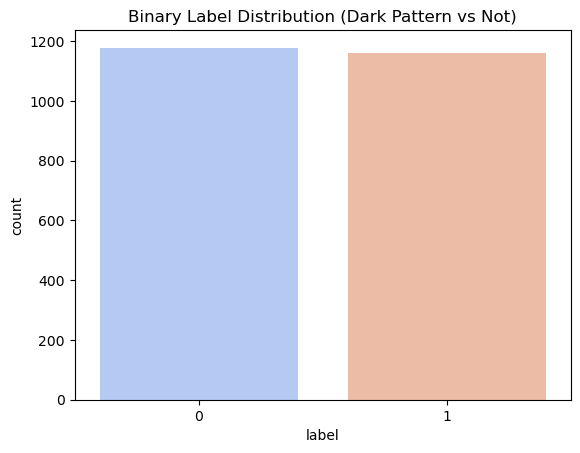

In [12]:
# before modelling checking if my classes are balanced or not .
sns.countplot(x=df['label'],palette='coolwarm')
plt.title("Binary Label Distribution (Dark Pattern vs Not)")
plt.show()

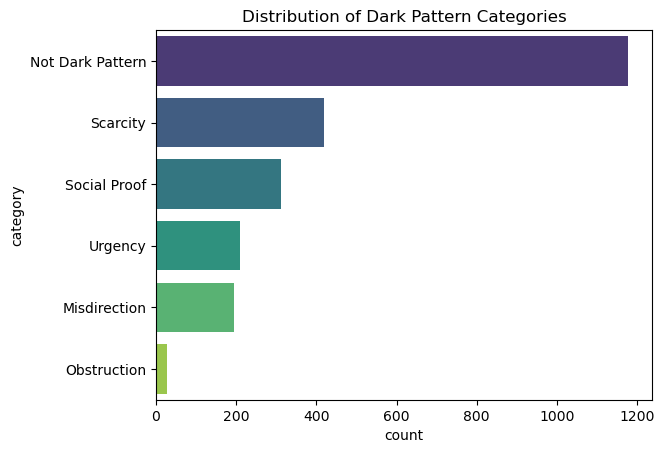

In [13]:
# checking the specific categories of Dark Patterns
sns.countplot(y=df['category'], order=df['category'].value_counts().index, palette='viridis')
plt.title("Distribution of Dark Pattern Categories")
plt.show()

In [14]:
# going to lower-case everything, remove special characters,remove stopwords and lemmatize words

stop_words = set(stopwords.words("english"))
lemmatizer=WordNetLemmatizer()

cleaned_text=[]
for text in df['text']:
    text=str(text).lower()
    text=re.sub(r'[^a-zA-Z\s]', '', text)

    words=word_tokenize(text)

    clean_words=[]
    for word in words:
        if word not in stop_words:
            clean_words.append(lemmatizer.lemmatize(word))


    cleaned_text.append(" ".join(clean_words))
df['clean_text']=cleaned_text


df.head()

,text,label,category,clean_text
0,FLASH SALE | LIMITED TIME ONLY Shop Now,1,Urgency,flash sale limited time shop
1,Pillowcases & Shams,0,Not Dark Pattern,pillowcase sham
2,Write a review,0,Not Dark Pattern,write review
3,"To start your return, simply click on the foll...",0,Not Dark Pattern,start return simply click following button add...
4,newsletter signup (privacy policy),0,Not Dark Pattern,newsletter signup privacy policy


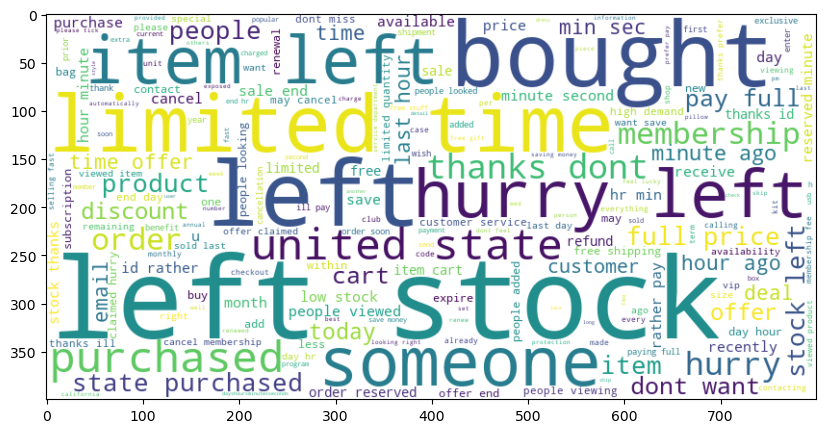

In [36]:
# Combine all Dark Pattern text
dark_text = " ".join(df[df['label']==1]['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(dark_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.show()

# Binary Classification

In [15]:
# splitting the data into training and testing sets

X_bin=df['clean_text']
y_bin=df['label']
X_train_bin,X_test_bin,y_train_bin,y_test_bin=train_test_split(X_bin,y_bin,test_size=.2,random_state=42,stratify=y_bin)


In [16]:
print(X_train_bin.shape)
print(X_test_bin.shape)

(1872,)
(468,)


In [17]:
# vectorizing the text3

tfidf_bin=TfidfVectorizer(ngram_range=(1, 2))

X_train_vec_b=tfidf_bin.fit_transform(X_train_bin)
X_test_vec_b=tfidf_bin.transform(X_test_bin)

# training Logistic Regression
model_bin=LogisticRegression()

model_bin.fit(X_train_vec_b,y_train_bin)

# predictions
y_pred_bin=model_bin.predict(X_test_vec_b)

In [18]:
# evaluation matrix
print(accuracy_score(y_test_bin,y_pred_bin))
print(classification_report(y_test_bin,y_pred_bin))

0.9444444444444444
              precision    recall  f1-score   support

           0       0.92      0.97      0.95       236
           1       0.97      0.92      0.94       232

    accuracy                           0.94       468
   macro avg       0.95      0.94      0.94       468
weighted avg       0.95      0.94      0.94       468



* the model achieved 94.4% accuracy

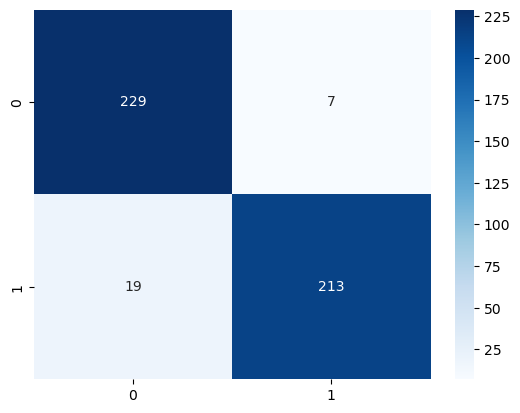

In [19]:
#confsuion matrix
cm=confusion_matrix(y_test_bin,y_pred_bin)
sns.heatmap(cm,annot=True,fmt='d', cmap='Blues')
plt.show()

In [20]:
# extracting important words based on model coefficients

feature_names=np.array(tfidf_bin.get_feature_names_out())
coefs = model_bin.coef_[0]   

top_n = 25
top_pos = np.argsort(coefs)[-top_n:][::-1]   
top_neg = np.argsort(coefs)[:top_n]         

print("Top features for class = 1 (dark pattern):")
print(list(feature_names[top_pos]))
print("\nTop features for class = 0 (not dark pattern):")
print(list(feature_names[top_neg]))

Top features for class = 1 (dark pattern):
['left', 'purchased', 'people', 'thanks', 'bought', 'limited', 'stock', 'time', 'hurry', 'minute', 'item', 'hour', 'someone', 'dont', 'cart', 'limited time', 'order', 'end', 'offer', 'ago', 'last', 'day', 'viewing', 'want', 'save']

Top features for class = 0 (not dark pattern):
['shop', 'remote', 'accessory', 'view', 'cooky', 'new', 'return', 'read', 'short', 'top', 'color', 'clothing', 'womens', 'baby', 'delivery', 'search', 'hair', 'help', 'stay', 'back', 'collection', 'review', 'story', 'filter', 'sleeve']


# Multiclass Classification

In [21]:
#splitting for Multiclass
X_multi=df['text']
y_multi=df['category']

#train-test split
X_train_multi,X_test_multi,y_train_multi,y_test_multi=train_test_split(X_multi,y_multi,test_size= .2 , random_state=42 ,stratify=y_multi)

#vectorizing
tfidf_multi=TfidfVectorizer()

X_train_vec_m = tfidf_multi.fit_transform(X_train_multi)
X_test_vec_m= tfidf_multi.transform(X_test_multi)



# Model-1 : Logistics Regression

In [22]:
lr_model=LogisticRegression(class_weight='balanced')

lr_model.fit(X_train_vec_m,y_train_multi)
y_pred_lr=lr_model.predict(X_test_vec_m)

print(accuracy_score(y_test_multi,y_pred_lr))

0.9337606837606838


# Model-2 : Naive Bayes

In [23]:
NB_model=MultinomialNB()

NB_model.fit(X_train_vec_m,y_train_multi)
y_pred_NB=NB_model.predict(X_test_vec_m)

print(accuracy_score(y_test_multi,y_pred_NB))

0.9294871794871795


# Model-3 : Random Forest

In [24]:
RF_model=RandomForestClassifier(class_weight='balanced', random_state=42)

RF_model.fit(X_train_vec_m,y_train_multi)
y_pred_RF=RF_model.predict(X_test_vec_m)

print(accuracy_score(y_test_multi,y_pred_RF))

0.938034188034188


# Model 4 : SVM (Support Vector Machine)

In [25]:
svm_model=LinearSVC()

svm_model.fit(X_train_vec_m,y_train_multi)
y_pred_svm=svm_model.predict(X_test_vec_m)

print(accuracy_score(y_test_multi,y_pred_svm))

0.9487179487179487


# Model 5: Gradient Boosting

In [26]:
gbm_model = GradientBoostingClassifier(learning_rate=0.1, random_state=42)


gbm_model.fit(X_train_vec_m, y_train_multi)
y_pred_gbm = gbm_model.predict(X_test_vec_m)

print(accuracy_score(y_test_multi,y_pred_gbm))

0.938034188034188


* The Linear SVM (Support Vector Machine) performed best with ~94.8% accuracy.

In [27]:
# 1. Get the feature names (vocabulary) from the multi-class vectorizer
feature_names = np.array(tfidf_multi.get_feature_names_out())

# 2. Loop through each category to find its specific "trigger words"
# svm_model.classes_ contains the category names (e.g., 'Urgency', 'Scarcity')
# svm_model.coef_ is a matrix of shape (n_classes, n_features)

for i, class_label in enumerate(svm_model.classes_):
    # Get the coefficients for this specific class
    class_coefs = svm_model.coef_[i]
    
    # Sort and get the top 15 highest positive weights
    # (These are the words that strongly push the model to predict THIS category)
    top_indices = np.argsort(class_coefs)[-15:][::-1]
    top_words = feature_names[top_indices]
    
    print(f"\nTop features for '{class_label}':")
    print(list(top_words))


--- SVM FEATURE IMPORTANCE ---

Top features for 'Misdirection':
['thanks', 'want', 'no', 'also', 'save', 'these', 'll', 'don', 'protect', 'without', 'fanstastic', 'rather', 'grab', 'special', 'full']

Top features for 'Not Dark Pattern':
['new', 'sign', 'view', 'as', 'back', 'read', 'guarantee', 'share', 'longer', 'cookies', 'might', 'of', 'basket', 'supply', 'stay']

Top features for 'Obstruction':
['cancel', 'membership', 'may', 'at', 'us', 'call', 'your', 'any', 'com', '800', 'the', 'to', 'program', 'by', 'vip']

Top features for 'Scarcity':
['left', 'stock', 'claimed', 'demand', 'only', 'fast', 'quantity', 'availability', 'available', 'selling', 'hurry', 'sellout', 'high', 'deal', 'almost']

Top features for 'Social Proof':
['purchased', 'bought', 'ago', 'someone', 'people', 'in', 'viewed', 'popular', 'added', 'viewing', 'this', 'their', 'just', 'times', 'users']

Top features for 'Urgency':
['time', 'ends', 'within', '04', 'minutes', '00', 'off', 'seconds', '00days00hours14minut

In [29]:
# Defining parameters to test & running Grid Search with 5-fold cross-validation
param_grid = {'C': [0.1, 1, 10, 100]} 

grid = GridSearchCV(LinearSVC(class_weight='balanced', random_state=42, max_iter=2000), param_grid, cv=5,scoring='accuracy',verbose=1)
grid.fit(X_train_vec_m, y_train_multi)

print("Best Parameters:", grid.best_params_)
print(f"Best Cross-Val Accuracy: {grid.best_score_:.4f}")

best_svm = grid.best_estimator_
y_pred_opt = best_svm.predict(X_test_vec_m)
print(f"Test Set Accuracy: {accuracy_score(y_test_multi, y_pred_opt):.4f}")
print(classification_report(y_test_multi, y_pred_opt))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Parameters: {'C': 10}
Best Cross-Val Accuracy: 0.9407
Test Set Accuracy: 0.9402
                  precision    recall  f1-score   support

    Misdirection       0.82      0.82      0.82        39
Not Dark Pattern       0.96      0.94      0.95       236
     Obstruction       1.00      1.00      1.00         5
        Scarcity       0.94      0.99      0.97        84
    Social Proof       0.95      0.94      0.94        62
         Urgency       0.91      0.98      0.94        42

        accuracy                           0.94       468
       macro avg       0.93      0.94      0.94       468
    weighted avg       0.94      0.94      0.94       468



* The hyperparameter tuning selected C=10 as the best parameter
* The final model achieves 94% accuracy on the test set

In [43]:
# What did the model learn?
# Green = Positive Signal (Suggests this category)
# Red = Negative Signal (Suggests NOT this category)
display(eli5.show_weights(best_svm, vec=tfidf_multi, top=15))


Generating Global Explanation Table...


In [45]:
# sanity check
test_text = "Hurry! Only 2 items left in stock."

display(eli5.show_prediction(best_svm, test_text, vec=tfidf_multi))